In [1]:
from chess import Board, pgn
from auxiliary_func import board_to_matrix
import torch
from deprecated_models.model4 import ChessModel4
from MiniMaia import MiniMaia, MiniMaiaSkipFC, MiniMaiaSkip
import pickle
import numpy as np
import random
import chess
import chess.gaviota

# Predictions

1. Prepare the Input Data
Convert the board state to a format suitable for the model:

In [2]:
def prepare_input(board: Board):
    matrix = board_to_matrix(board)
    X_tensor = torch.tensor(matrix, dtype=torch.float32).unsqueeze(0)
    return X_tensor

2. Load the Model & mapping and Move to GPU if Available

In [ ]:
tablebase_path = "/home/wyatt/Documents/capstone/Gaviota/gaviota"


# Load the mapping

with open("../../models/flipped_board_data_move_to_int", "rb") as file:
    move_to_int = pickle.load(file)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Load the model
model = ChessModel4(num_classes=len(move_to_int))
model.load_state_dict(torch.load("../../models/flipped_boards_model_final_model.pth"))
model.to(device)
model.eval()

# model 2
model2 = MiniMaiaSkipFC(num_classes=len(move_to_int), num_blocks=6)
model2.load_state_dict(torch.load("../../models/minimaia_with_skip_fc.pth"))
model2.to(device)
model.eval()

int_to_move = {v: k for k, v in move_to_int.items()}


# Function to make predictions
def predict_move(board: Board, pseudo_temp: int = 2, endgame_safety: float = 0.75):

    X_tensor = prepare_input(board).to(device)
    
    with torch.no_grad():
        logits = model2(X_tensor)
    
    logits = logits.squeeze(0)  # Remove batch dimension
    probabilities = torch.softmax(logits, dim=0).cpu().numpy()  # Convert to probabilities
    argsort = np.argsort(probabilities)[::-1] # record what moves sorted probs correspond to


    sorted_probs = probabilities
    sorted_probs.sort()
    sorted_probs = sorted_probs[::-1]
    legal_moves = list(board.legal_moves)
    legal_moves_uci = [move.uci() for move in legal_moves]

    # # endgame process
    endgame_safety_select = random.random()
    if len(board.piece_map()) < 6 and endgame_safety_select < endgame_safety: 
        with chess.gaviota.open_tablebase(tablebase_path) as tablebase:
            curr_dtm = tablebase.probe_dtm(board)
            if curr_dtm > 0:
                for idx, prob in enumerate(sorted_probs):
                    move = int_to_move[argsort[idx]]
                    if idx > 20:
                        break
                    if move not in legal_moves_uci:
                        continue
                    
                    board.push_uci(move)
                    temp_dtm = tablebase.probe_dtm(board)

                    if board.is_checkmate():
                        board.pop()
                        return move
                    if 0 < -temp_dtm < curr_dtm:
                        board.pop()
                        return move
                    else:
                        board.pop()

    
    for i in range(10): # try finding a random legal move 10 times
        selection = random.random() ** pseudo_temp
        collective_sum = 0
        idx = 0
        for prob in sorted_probs:
            # print(prob)
            collective_sum += prob
            if selection < collective_sum:
                move = int_to_move[argsort[idx]]
                if move in legal_moves_uci:
                    return move
                else:
                    break
            idx += 1

    # selects most popular move
    idx = 0
    for prob in sorted_probs:
        move = int_to_move[argsort[idx]]
        if move in legal_moves_uci:
            return move
        idx += 1
    return None

Using device: cuda


3. Use the ```predict_move``` function to get the best move and its probabilities for a given board state:

In [178]:
# Initialize a chess board
board = Board()

In [ ]:
# Clear board
board.clear()

# Place pieces: White King e4, Pawn d5; Black King e7
board.set_piece_at(chess.E4, chess.Piece(chess.KING, chess.WHITE))
board.set_piece_at(chess.D5, chess.Piece(chess.PAWN, chess.WHITE))
board.set_piece_at(chess.E7, chess.Piece(chess.KING, chess.BLACK))
board.set_piece_at(chess.C7, chess.Piece(chess.PAWN, chess.WHITE))

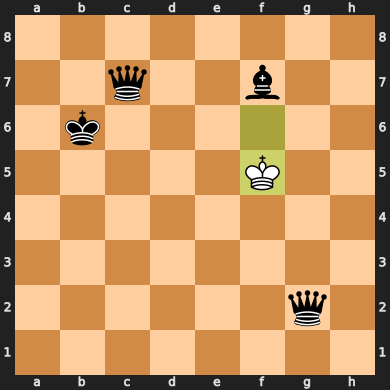

In [391]:
board

In [390]:

# board.push_uci("d8e8")
board.pop()

Move.from_uci('g2g6')

torch.Size([1, 1932])
<class 'torch.Tensor'>
torch.Size([1932])
<class 'torch.Tensor'>
<class 'numpy.ndarray'>
f5f6


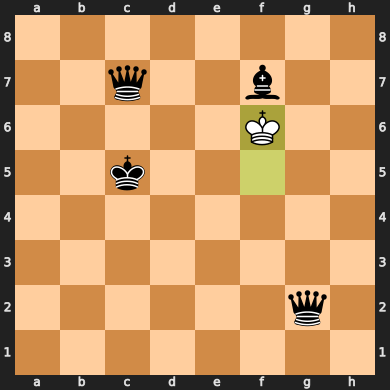

In [395]:
# Predict and make a move
best_move = predict_move(board)
print(best_move)
board.push_uci(best_move)
board

In [ ]:
print(str(pgn.Game.from_board(board)))